# Reconnaissance de caractères avec [Nengo](https://www.nengo.ai/nengo-dl/index.html)


Cette page est tiré d'un [tutoriel de Nengo](https://www.nengo.ai/nengo-dl/examples/spiking-mnist.html) qui montre comment reconnaître des caractères écrits avec l'extension [Nengo](https://www.nengo.ai/nengo-dl/index.html).

Ce tutoriel utilise aussi l'extension [Tensorflow](https://www.tensorflow.org/?hl=fr), développée par [Google Brain Team](https://research.google.com/teams/brain/?hl=he) pour le *deep learnin* et le *machine learning*. On trouve des tutoriels [ici](https://pythonguides.com/tensorflow/). 

Dans ce module, on utilise les [fichiers de données](https://keras.io/api/datasets/) d'entraînement du sous-module [Kera](https://keras.io/about/), plus exactement des images de  [chiffres manuscrits](https://keras.io/api/datasets/mnist/) traduites sous formes de matrices de points utilisables directement sous Python. Ceci nous économise la phase d'acquisition et de traitement d'image, qu'il faudrait faire sinon avec par exemple l'extension [Scikit-image](https://scikit-image.org/docs/stable/user_guide/numpy_images.html).

In [65]:
%matplotlib inline

import nengo
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nengo_dl

(train_images, train_labels), (
    test_images,
    test_labels,
) = tf.keras.datasets.mnist.load_data()


L'extension [matplotlib.pyplot](https://matplotlib.org/stable/tutorials/introductory/quick_start.html) propose la commande [imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) qui permet d'afficher des matrices de points, représentant donc ici l'image d'un chiffre manuscrit. Ci-dessous, l'une des images de la liste de matrices `train_images` est affichée en précisant son étiquette (elles sont stockées dans la liste `train_labels`) et sa taille en nombre de points avec la méthode [shape](https://www.digitalocean.com/community/tutorials/python-shape-method).

La taille de l'image est : (28, 28)


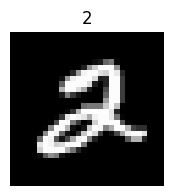

In [66]:
num = 5    # changer ce chiffre pour une autre image
plt.figure(figsize=(2,2))
plt.imshow(train_images[num], cmap ="gray")
plt.title(str(train_labels[num]))
plt.axis("off")
print(f'La taille de l\'image est : {test_images[num].shape}')

Pour affichier plus d'images, il suffit de faire une boucle.

/home/mathieu/Sync/informatique/programmation/python/python_par_jupyter/.venv/lib/python3.10/site-packages/nengo_dl/simulator.py:2066: RuntimeWarning: Simulator with model=Model: <Network (unlabeled) at 0x7fb4a930cf10>, dt=0.001000 was deallocated while open. Simulators should be closed manually to ensure resources are properly freed.
  warnings.warn(


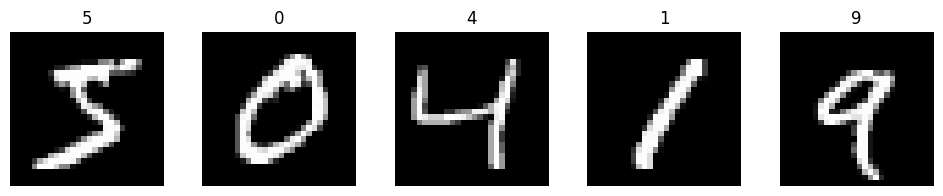

In [67]:
# affichons les premiers chiffres
plt.figure(figsize=(12,2))
n = 5
for i in range(n):
    plt.subplot(1,n,i+1)
    plt.imshow(train_images[i], cmap="gray")
    plt.axis("off")
    plt.title(str(train_labels[i]))

Pour la suite de l'exercice, ces images sont [applaties](https://www.w3schools.com/python/numpy/numpy_array_reshape.asp). Elles pourront toujours être réaffichées en changeant la forme avant l'affichage avec [numpy.reshape](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html).

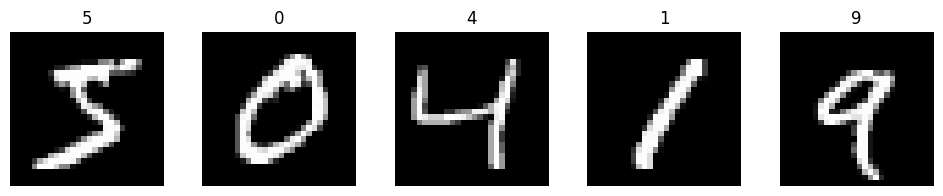

In [68]:

# on applatit les images
train_images = train_images.reshape((train_images.shape[0],-1))
test_images = test_images.reshape((test_images.shape[0],-1))

# malgré tout, on peut toujours afficher ces images
plt.figure(figsize=(12,2))
n = 5
for i in range(n):
    plt.subplot(1,n,i+1)
    # pour afficher les images applaties, on les "re-forme"
    plt.imshow(np.reshape(train_images[i],(28,28)), cmap="gray")
    plt.axis("off")
    plt.title(str(train_labels[i]))


Dans la phase suivante, on définit le réseau neuronal à utiliser avec Nengo.

In [69]:
with nengo.Network(seed=0) as net:
    # set some default parameters for the neurons that will make
    # the training progress more smoothly
    net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([100])
    net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    net.config[nengo.Connection].synapse = None
    neuron_type = nengo.LIF(amplitude=0.01)

    # this is an optimization to improve the training speed,
    # since we won't require stateful behaviour in this example
    nengo_dl.configure_settings(stateful=False)

    # the input node that will be used to feed in input images
    inp = nengo.Node(np.zeros(28 * 28))

    # add the first convolutional layer
    x = nengo_dl.Layer(tf.keras.layers.Conv2D(filters=32, kernel_size=3))(
        inp, shape_in=(28, 28, 1)
    )
    x = nengo_dl.Layer(neuron_type)(x)

    # add the second convolutional layer
    x = nengo_dl.Layer(tf.keras.layers.Conv2D(filters=64, strides=2, kernel_size=3))(
        x, shape_in=(26, 26, 32)
    )
    x = nengo_dl.Layer(neuron_type)(x)

    # add the third convolutional layer
    x = nengo_dl.Layer(tf.keras.layers.Conv2D(filters=128, strides=2, kernel_size=3))(
        x, shape_in=(12, 12, 64)
    )
    x = nengo_dl.Layer(neuron_type)(x)

    # linear readout
    out = nengo_dl.Layer(tf.keras.layers.Dense(units=10))(x)

    # we'll create two different output probes, one with a filter
    # (for when we're simulating the network over time and
    # accumulating spikes), and one without (for when we're
    # training the network using a rate-based approximation)
    out_p = nengo.Probe(out, label="out_p")
    out_p_filt = nengo.Probe(out, synapse=0.1, label="out_p_filt")


Nous construisons maintenant un premier simulateur pour ce réseau en utilisant [NegoDl](https://www.nengo.ai/nengo-dl/user-guide.html) qui utilise [Nengo](https://www.nengo.ai/nengo/user-guide.html) et [Keras](https://www.tensorflow.org/guide/keras/train_and_evaluate?hl=fr), lui même venant de l'extension [TensoFlow](https://www.tensorflow.org/?hl=fr).

In [74]:
minibatch_size = 200
sim = nengo_dl.Simulator(net, minibatch_size=minibatch_size)

|                     Building network (0%)                    | ETA:  --:--:--
|###                   Building network (5%)                     | ETA: 0:00:01
Build finished in 0:00:00
|#                         Optimizing graph                           | 0:00:00
|#             Optimizing graph: operator simplificaton               | 0:00:00
Optimizing graph: operator simplificaton finished in 0:00:00
|#                Optimizing graph: merging operators                 | 0:00:00
Optimizing graph: merging operators finished in 0:00:00
|#                Optimizing graph: ordering signals                  | 0:00:00
Optimizing graph: ordering signals finished in 0:00:00
|#                Optimizing graph: creating signals                  | 0:00:00
Optimizing graph: creating signals finished in 0:00:00
Optimization finished in 0:00:00
|#                        Constructing graph                          | 0:00:00
| #                       Constructing graph                          | 0:

Maintenant nous entrons nos données de test et d'apprentissage.

In [75]:
# add single timestep to training data
train_images = train_images[:, None, :]
train_labels = train_labels[:, None, None]

# when testing our network with spiking neurons we will need to run it
# over time, so we repeat the input/target data for a number of
# timesteps.
n_steps = 30
test_images = np.tile(test_images[:, None, :], (1, n_steps, 1))
test_labels = np.tile(test_labels[:, None, None], (1, n_steps, 1))


Pour mesure la performance de notre reconnaissance, nous utilisons une fonction développée ici.

In [78]:
def classification_accuracy(y_true, y_pred):
    return tf.metrics.sparse_categorical_accuracy(y_true[:, -1], y_pred[:, -1])

On fait un premier calcul de la qualité de la reconnaissance avant l'entraînement.

In [73]:
# note that we use `out_p_filt` when testing (to reduce the spike noise)
sim.compile(loss={out_p_filt: classification_accuracy})
print(
    "Accuracy before training:",
    sim.evaluate(test_images, {out_p_filt: test_labels}, verbose=0)["loss"],
)

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
Constructing graph: pre-build stage finished in 0:00:00
|             Constructing graph: build stage (0%)             | ETA:  --:--:--
|############# Constructing graph: build stage (21%)             | ETA: 0:00:00
|##############Constructing graph: build stage (63%)             | ETA: 0:00:00
|############Constructing graph: build stage (100%)############| ETA:  00:00:00
Constructing graph: build stage finished in 0:00:00
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
Constructing graph: pre-build stage finished in 0:00:00
|             Constructing graph: build stage (0%)             | ETA:  --:--:--
|##########    Constructing graph: build stage (15%)             | ETA: 0:00:00
|##############Constructing graph: build stage (47%)             | ETA: 0:00:00
|############Constructing graph: build stage (100%)############| ETA:  00:00:00
Constructing graph: build stage fini

Maintenant, nous sommes prêt à entrainer notre réseau. Pour que l'exemple reste assez rapide, nous téléchargeons des poids qui auront été précalculés. Pour ce téléchargement, nous utilisaons l'extension [urllib](https://docs.python.org/3/library/urllib.html) qui regroupe des commandes pour manipuler les [url](https://developer.mozilla.org/fr/docs/Learn/Common_questions/Web_mechanics/What_is_a_URL). Dans cette extension le module [urllib.request](https://docs.python.org/3/library/urllib.request.html#module-urllib.request) définit une classe qui aide l'ouverture des URL.

On peut aussi s'en passer et refaire les calculs depuis zéro en entrant `do_training=True`.

In [76]:
from urllib.request import urlretrieve

do_training = False
if do_training:
    # run training
    sim.compile(
        optimizer=tf.optimizers.RMSprop(0.001),
        loss={out_p: tf.losses.SparseCategoricalCrossentropy(from_logits=True)},
    )
    sim.fit(train_images, {out_p: train_labels}, epochs=10)

    # save the parameters to file
    sim.save_params("./mnist_params")
else:
    # download pretrained weights
    urlretrieve(
        "https://drive.google.com/uc?export=download&"
        "id=1l5aivQljFoXzPP5JVccdFXbOYRv3BCJR",
        "mnist_params.npz",
    )

    # load parameters
    sim.load_params("./mnist_params")

Et maintenant nous pouvons vérifier la précision de notre classification avec ces paramètres qui ont été entrainés.

In [77]:
sim.compile(loss={out_p_filt: classification_accuracy})
print(
    "Accuracy after training:",
    sim.evaluate(test_images, {out_p_filt: test_labels}, verbose=0)["loss"],
)


ValidationError: node data: should have rank 3 (batch_size, n_steps, dimensions), found rank 4

In [ ]:
data = sim.predict(test_images[:minibatch_size])

for i in range(5):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i, 0].reshape((28, 28)), cmap="gray")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.plot(tf.nn.softmax(data[out_p_filt][i]))
    plt.legend([str(i) for i in range(10)], loc="upper left")
    plt.xlabel("timesteps")
    plt.ylabel("probability")
    plt.tight_layout()



https://www.nengo.ai/nengo-dl/examples/spiking-mnist.html
